Implement V-type atom system

In [1]:
import numpy as np
from qutip import *
import matplotlib.pyplot as plt


In [9]:
plt.rcParams.update({
    # LaTeX rendering and font configuration
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],  # mathpazo corresponds to Palatino font
    "font.size": 18,  # Base font size
    
    # Font sizes for specific elements
    "axes.titlesize": 22,        # Axis title
    "axes.labelsize": 20,         # Axis labels
    "xtick.labelsize": 18,        # X-ticks
    "ytick.labelsize": 18,        # Y-ticks
    "legend.fontsize": 18,        # Legend
    "figure.titlesize": 24,       # Figure title
    
    # LaTeX preamble packages
    "text.latex.preamble": r"""
        \usepackage{amsmath}
        \usepackage{amsfonts}
        \usepackage{amssymb}
        \usepackage{lmodern}
        \usepackage{mathpazo}
    """
})

In [158]:
# -------------------------------
# 1. Define Parameters
# -------------------------------
Delta   = 0.0          # Cavity detuning 
Delta1  = 0          # Detuning for excited state 1
Delta2  = 0          # Detuning for excited state 2
g       = 0.1          # Coupling strength
phi     = 0    # Phase for the second interaction term
eta     = g/2          # Amplitude for the pump term
kappa  = 1.0
# Field mode parameters
N_cutoff = 10         # Hilbert space truncation for the bosonic mode

# -------------------------------
# 2. Build the Hilbert Spaces and Field Operators
# -------------------------------
# Create the bosonic mode operators in the Fock basis
a    = destroy(N_cutoff)       # annihilation operator for the cavity field
adag = a.dag()                    # creation operator

# Identity for the field Hilbert space
I_field = qeye(N_cutoff)

# Three-level atomic  Hilbert space
dim_atom = 3
I_atom = qeye(dim_atom)


In [159]:

# -------------------------------
# 3. Define the Gell-Mann Matrices for SU(3)
# -------------------------------
# Standard definitions (using the conventional normalization)
# Note: The Gell-Mann matrices are 3x3 numpy arrays that we wrap with Qobj.

# lambda1:
lambda1 = Qobj([[0, 1, 0],
                   [1, 0, 0],
                   [0, 0, 0]], dims=[[3],[3]])

# lambda2:
lambda2 = Qobj([[0, -1j, 0],
                   [1j,  0, 0],
                   [0,   0, 0]], dims=[[3],[3]])

# lambda3:
lambda3 = Qobj([[1, 0, 0],
                   [0,-1, 0],
                   [0, 0, 0]], dims=[[3],[3]])

# lambda4:
lambda4 = Qobj([[0, 0, 1],
                   [0, 0, 0],
                   [1, 0, 0]], dims=[[3],[3]])

# lambda5:
lambda5 = Qobj([[0, 0, -1j],
                   [0, 0,  0],
                   [1j,0,  0]], dims=[[3],[3]])

# lambda6:
lambda6 = Qobj([[0, 0, 0],
                   [0, 0, 1],
                   [0, 1, 0]], dims=[[3],[3]])

# lambda7:
lambda7 = Qobj([[0, 0, 0],
                   [0, 0, -1j],
                   [0, 1j, 0]], dims=[[3],[3]])

# lambda8:
lambda8 = (1/np.sqrt(3)) * Qobj([[1, 0, 0],
                                    [0, 1, 0],
                                    [0, 0,-2]], dims=[[3],[3]])



In [160]:
# -------------------------------
# 4. Define the Number Operators for the Atomic Levels
# -------------------------------
# According to the definitions:
#   N1 = I/3 + lambda3 + (1/sqrt(3))*lambda8
#   N0 = I/3 - lambda3 + (1/sqrt(3))*lambda8
#   N2 = I/3 - (1/sqrt(3))*lambda8

N1 = (I_atom/3) + lambda3 + (1/np.sqrt(3))*lambda8
N0 = (I_atom/3) - lambda3 + (1/np.sqrt(3))*lambda8
N2 = (I_atom/3) - (1/np.sqrt(3))*lambda8

# -------------------------------
# 5. Build the Hamiltonian
# -------------------------------
# (a) Field (cavity) term: -Delta * a^\dagger a
H_field = -Delta * tensor(adag * a, I_atom)

# (b) Atomic detuning terms: sum_{m=1,2} -Delta_m * N_m
# Here m=1 corresponds to N1 and m=2 corresponds to N2.
H_atom = -Delta1 * tensor(I_field, N1) - Delta2 * tensor(I_field, N2)

# (c) Interaction term:
#    g * [ a^\dagger (lambda1 - i lambda2)
#          + exp(-i phi) a^\dagger (lambda6 - i lambda7) + h.c. ]
#
# Define the two interaction operators on the atomic (qutrit) space:
op1 = lambda1 - 1j * lambda2
op2 = lambda6 - 1j * lambda7

# The interaction terms (with a^\dagger acting on the field):
H_int = g * ( tensor(adag, op1) + np.exp(-1j*phi) * tensor(adag, op2) )
# Add the Hermitian conjugate (h.c.) to make it self-adjoint:
H_int = H_int + H_int.dag()

# (d) Pump term:
#    i * eta * (a^\dagger - a) acting only on the field.
H_pump = 1j * eta * tensor(adag - a, I_atom)

# Total Hamiltonian:
H = H_field + H_atom + H_int + H_pump


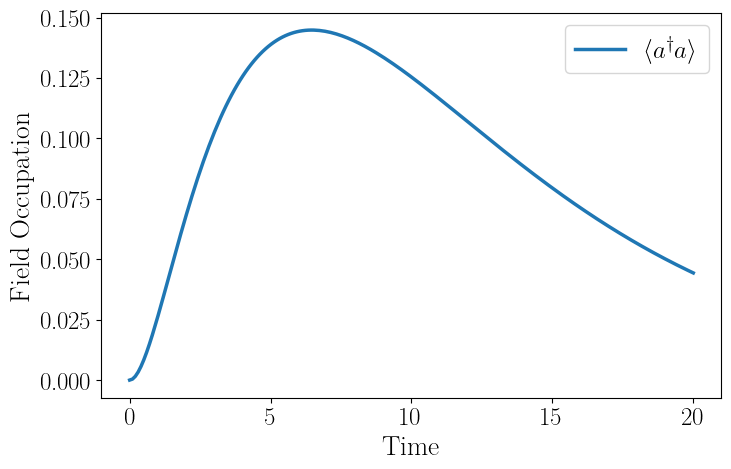

In [163]:
# -------------------------------
# 6.  Hamiltonian and  Spectrum
# -------------------------------
# Eigenenergies:
e_vals = H.eigenenergies()

# -------------------------------
# 7.Time Evolution 
# -------------------------------
# Prepare an initial state: for instance, field vacuum ⊗ a superposition of atomic states.
psi_field = basis(N_cutoff, 0)
# For the atomic state, we use an equal superposition (customize as needed):
psi_atom = (basis(3, 0)).unit()
psi0 = tensor(psi_field, psi_atom);

# Define a time array for propagation:
t_list = np.linspace(0, 2/g, 200);

c_ops = [np.sqrt(kappa) * tensor(a, I_atom)]
# Evolve the state under H using QuTiP's mesolve:
result = mesolve(H, psi0, t_list, c_ops, []);

# As an example, compute the expectation value of the field number operator <a†a>
n_expect = expect(tensor(adag * a, I_atom), result.states);

# Plot the field occupation number versus time:
plt.figure(figsize=(8, 5))
plt.plot(t_list, n_expect, label=r'$\langle a^\dagger a\rangle$', lw=2.5)
plt.xlabel('Time')
plt.ylabel('Field Occupation')
plt.legend()
plt.show()


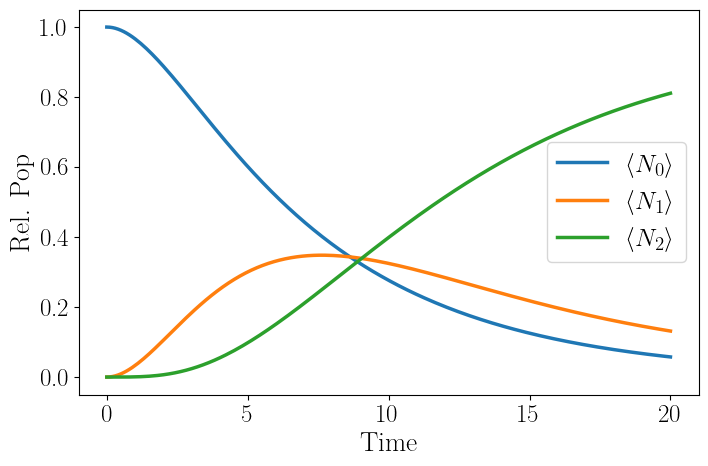

In [162]:
### Plot relative populations

P0 = Qobj([[1, 0, 0],
              [0, 0, 0],
              [0, 0, 0]], dims=[[3],[3]])
P1 = Qobj([[0, 0, 0],
              [0, 1, 0],
              [0, 0, 0]], dims=[[3],[3]])
P2 = Qobj([[0, 0, 0],
              [0, 0, 0],
              [0, 0, 1]], dims=[[3],[3]])

P0_full = tensor(I_field, P0)
P1_full = tensor(I_field, P1)
P2_full = tensor(I_field, P2)

pop0 = expect(P0_full, result.states)
pop1 = expect(P1_full, result.states)
pop2 = expect(P2_full, result.states)
pt = pop0 + pop1+pop2

plt.figure(figsize=(8, 5))
plt.plot(t_list, pop0, label=r'$\langle N_0\rangle$', lw=2.5)
plt.plot(t_list, pop1, label=r'$\langle N_1 \rangle$', lw=2.5)
plt.plot(t_list, pop2, label=r'$\langle N_2 \rangle$', lw=2.5)

plt.xlabel('Time')
plt.ylabel('Rel. Pop')
plt.legend()
plt.show()